### Modelling Spread of Diseases using Agent Based Modelling

In this project, the aim is to model the spread of diseases across individuals over time, accounting for the movement of individuals across a grid space. The set up is as follows:

Agent: Individual (location, infected, transmission rate, recovery rate, vacc status) The transmission rate dependent on vacc status and recovery rate is dependent on the strength of the disease, which factors their values up or down given strength, 
Potential other things to add: immunity after infection.

Disease (Strength) and also another factor of minimum recovery timestep, which is the minimum amount of time steps before any recovery (using the recovery rate) can be taken.

Environment: Consists of 10 different nodes/locations, where each node is has a 50x50 grid space, where agents can be at (agent.location)

Location Rules:

1. An agent can choose one of three choices, stay where they are, move to another grid space within the node, or move to another grid space at another node
2. Agents can move freely from one node to any other at one timestep, no hinderances besides capacity in 3.
3. If the grid space is already occupied by an agent, randomly select another space in the node, otherwise if all taken, randomly select another node and grid space.

Infection Rules:

1. An agent can be infected at a timestep if they are within a 5x5 grid space of an infected individual, dependent on their transmission rate.
2. The probability of the agent recovering from the infection depends on the recovery rate.
3. An individual that is infected has should not move from their location

Parameters to collect:

- Percentage of infected at each timestep for each node
- Percentage of infected by vacc status
- Average infections per population in node

Things to consider:
- Deaths (Death Rate Probability - Dependent on vaccs, and also immunity)
- Try one city first, if works then expand. 
- 3 parameters to determine movement of individual across grid space.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import correlate2d
from matplotlib.animation import FuncAnimation

cmap = ListedColormap(['white', 'grey', 'red', 'blue'])
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

In [58]:
infection_rate = 0.01 # percentage of people infected
vacc_rate = 0.2 # percentage of people vaccinated
n_humans = 1000
grid_space = 100 #nxn grid
n_nodes = 10
steps = 100
scan_space = 3
min_infect_days = 7
death_infect_days = 14
death_chance = 0.03
decision_vaccine = 0.3
multiplier_factor = 1.1 
vaccine_multiplier = 0.3 # higher vacc multiplier means lower effectiveness of vaccine
immunity_multiplier = 0.1 # higher immunity multiplier means lower effectiveness of immunity
vaccine_randomness = 0.5 # can be used to increase or decrease the randomness of the vaccine
immunity_randomness = 0.1 # can be used to increase or decrease the randomness of the vaccine

## Agent

In [60]:
class Human():

    def __init__(self, vaccine_multiplier, immunity_multiplier):
        self.infected = np.random.random() < infection_rate
        self.transmission_rate = np.random.random() # getting infected chance
        self.recovery_rate = np.random.random()
        self.vaccine = np.random.random() < vacc_rate
        self.infected_time = 0
        self.immunity = False # if infected and recovered, then immune = True
        self.dead = False
        self.vaccine_multiplier = vaccine_multiplier
        self.immunity_multiplier = immunity_multiplier

    '''Choose a new location to move to based on random probability'''
    def choose_newlocation(self):
        if self.infected: # stay at location
            self.decision = 0
        else: # make choice to move to a new location or stay
            # using a dirichlet distribution, which is distribution over vectors of probabilities that sum to 1 (2 for now, will up to 3 when create cities)
            random_moveto = np.random.dirichlet(np.ones(2), size=1)
            self.decision = np.argmax(random_moveto)
        return self.decision
    
    def recovery(self): # run at each step
        chance_recovery = np.random.random() #move down later
        #print('chance_recovery', chance_recovery)
        if self.infected:
            if self.infected_time > min_infect_days:
                if self.vaccine:
                    vaccine_multiplier_self = np.random.normal(self.vaccine_multiplier, vaccine_randomness) # introduce randomness to vaccine for human
                    #print('vac str', vaccine_multiplier_self)
                    chance_recovery = chance_recovery * vaccine_multiplier_self
                    #print('aftvac', chance_recovery)
                if self.immunity:
                    immunity_multiplier_self = np.random.normal(self.immunity_multiplier, immunity_randomness) # introduce randomness to immunity for human
                    #print('imm str', immunity_multiplier_self)
                    chance_recovery = chance_recovery * immunity_multiplier_self
                    #print('imm adj', chance_recovery)
                if chance_recovery > self.recovery_rate: # recovered
                    self.infected = False
                    self.immunity = True
                    self.infected_time = 0
                    # random chance to get vaccine after recovery
                    if np.random.random() > decision_vaccine:
                        self.vaccine = True
                else:  # not recovered
                    self.infected_time += 1
            else:
                self.infected_time += 1
        else:
            pass
        return self.infected
    
    def infect(self, n_infected): # run at each step
        chance_infection = np.random.random() #move down later, just for checking
        #print('Initial', chance_infection)
        # account for more infected people, more chance of infection
        q_infected = self.infected
        adjusted_chance_infection = chance_infection * (multiplier_factor ** (n_infected - 1))
        #print('After Multi', adjusted_chance_infection)
        adjusted_chance_infection = min(adjusted_chance_infection, 1)
        if self.infected:
            pass
        else: # not infected
            if n_infected > 0:
                # account for vaccine and immunity
                if self.vaccine:
                    vaccine_multiplier_self = np.random.normal(self.vaccine_multiplier, vaccine_randomness)
                    #print('vac str', vaccine_multiplier_self)
                    adjusted_chance_infection = adjusted_chance_infection * vaccine_multiplier_self
                    #print('aftvac', adjusted_chance_infection)
                if self.immunity:
                    immunity_multiplier_self = np.random.normal(self.immunity_multiplier, immunity_randomness)
                    #print('imm str', immunity_multiplier_self)
                    adjusted_chance_infection = adjusted_chance_infection * immunity_multiplier_self
                    #print('imm adj', adjusted_chance_infection)
                # if chance of infection is greater than transmission rate, then infected
                if adjusted_chance_infection > self.transmission_rate:
                    self.infected = True
                    self.infected_time = 0
        return q_infected, self.infected
    
    def death(self):
        chance_death = np.random.random() < death_chance
        if chance_death and self.infected_time > death_infect_days:
            self.dead = True

## Environment

In [61]:
class Suburb():
    # create a 50x50 grid space
    def __init__(self):
        self.grid = np.zeros((grid_space,grid_space))
        self.humans = []

    '''Populates the grid space with humans, initial configuration'''
    def populate(self, n_humans, vaccine_multiplier, immunity_multiplier):
        # randomly place humans around in the grid, 1 person per grid space
        self.humans = [Human(vaccine_multiplier, immunity_multiplier) for i in range(n_humans)]
        for human in self.humans:
            x = np.random.randint(0,grid_space)
            y = np.random.randint(0,grid_space)
            # check if the grid space is already occupied
            while self.grid[x,y] != 0:
                x = np.random.randint(0,grid_space)
                y = np.random.randint(0,grid_space)
            if human.infected:
                self.grid[x,y] = 2 # if infected
            else:
                self.grid[x,y] = 1 # if not infected
            human.location = (x,y) # save location of human
    
    '''checks the grid space around each human to find number of infected people''' 
    def scan(self, human):
        # find neighbours of human
        x, y = human.location[0], human.location[1]
        #neighbours = []
        # set boundary constraints
        x_min = max(0, x-scan_space)
        x_max = min(grid_space-1, x+scan_space)
        y_min = max(0, y-scan_space)
        y_max = min(grid_space-1, y+scan_space)
        neighbours = self.grid[x_min:x_max+1, y_min:y_max+1]
        infected = np.sum(neighbours == 2)
        if human.infected:
            return(infected - 1) #number of infected humans around the human
        else:
            return(infected) #number of infected humans around the human
        
    def move(self, human):
        # decide whether to move or not based on human decision
        decision = human.choose_newlocation()
        if decision == 1: #not infected, move
            # move to a new location
            x = np.random.randint(0,grid_space)
            y = np.random.randint(0,grid_space)
            # check if the grid space is already occupied
            while self.grid[x,y] != 0:
                x = np.random.randint(0,grid_space)
                y = np.random.randint(0,grid_space)
            # update old location to 0
            self.grid[human.location[0], human.location[1]] = 0

            # update human location
            human.location = (x,y)
            self.grid[x,y] = 1
        else: #update grid space 
            # if infected, stay at location
            if human.infected:
                self.grid[human.location[0], human.location[1]] = 2
            else:
                self.grid[human.location[0], human.location[1]] = 1

    def remove_replace_dead(self, human):
        if human.dead:
            self.humans.remove(human)
            # replace with new human at same location
            new_human = Human(vaccine_multiplier, immunity_multiplier)
            new_human.location = human.location
            self.grid[human.location[0], human.location[1]] = 1
            self.humans.append(new_human)

    def one_step(self):
        # check number of infected people
        for human in self.humans:
            n_infected = self.scan(human)
            human.recovery()
            human.infect(n_infected)
            self.move(human)
        percent_infected = np.sum(self.grid == 2)
        return percent_infected
    
    def step(self, n_humans, n_steps, show_plot = False, vaccine_multiplier = 0.5, immunity_multiplier=0.5):
        # initialize grid space
        self.populate(n_humans, vaccine_multiplier, immunity_multiplier)
        # check number of infected people
        init_percent_infected = np.sum(self.grid == 2)/n_humans
        # create array for record per step
        record = np.zeros(n_steps, dtype=float)
        record[0] = init_percent_infected
        # create array for infections per step
        infections = np.zeros(n_steps, dtype=float)
        # create array for vaccine rate overtime
        vaccine_perc = np.zeros(n_steps, dtype=float)
        # deaths
        deaths = np.zeros(n_steps, dtype=float)
        # number of humans
        total_hum = np.zeros(n_steps, dtype=float)

        n_steps_plot = n_steps//10

        # show initial plot
        if show_plot is True:
            fig, axs = plt.subplots(1, n_steps_plot, figsize=(22, 4)) 

        for step in range(1,n_steps):
            # number of infected people
            infected_at_step = 0
            vaccine_at_step = 0
            deaths_at_step = 0
            n_infected = np.sum(self.grid == 2)
            for human in self.humans:
                # check if human is dead
                human.death()
                self.remove_replace_dead(human)
                infected_prior = human.infected
                n_infected = self.scan(human)
                human.recovery()
                human.infect(n_infected)
                infected_after = human.infected
                
                # if not infected before but infected after, then infected
                if not infected_prior and infected_after:
                    infected_at_step += 1
                
                # total vacc people
                if human.vaccine:
                    vaccine_at_step += 1

                # death rate
                if human.dead:
                    deaths_at_step += 1
                # move human
                self.move(human)
                
            percent_infected = np.sum(self.grid == 2)/n_humans
            record[step] = percent_infected
            percentage_infected = infected_at_step/n_humans
            infections[step] = percentage_infected
            vaccine_perc[step] = vaccine_at_step/n_humans
            deaths[step] = deaths_at_step/n_humans
            total_hum[step] = n_humans

            # save plot of grid space at every 10 steps, including the last step
            # plot of grid space at every 10 steps, including the last step, in a 1x5 side by side plo     

            if step % 10 == 0 and show_plot is True:
                ax = axs[(step // 10)-1]
                ax.imshow(self.grid, cmap=cmap, norm=norm)
                ax.set_title('Step {}'.format(step))
            
        return record, infections, vaccine_perc, deaths, total_hum 

## Hyperparameter Tuning

We will observe 3 parameters of interest:
1. The percentage of infected in the population at any given time
2. The infection rate per time step
3. The death rate per time step

In [107]:
# initial parameters
infection_rate = 0.01 # percentage of people infected
vacc_rate = 0.2 # percentage of people vaccinated
n_humans = 1000
grid_space = 100 #nxn grid
steps = 100

# disease parameters
scan_space = 3 # controls transmission space
min_infect_days = 7
death_infect_days = 14 # minimum number of days before death can occur
death_chance = 0.03 # also controls the strength of the disease

# vaccine parameters and immunity parameters
vaccine_multiplier = 0.3 # higher vacc multiplier means lower effectiveness of vaccine
immunity_multiplier = 0.2 # higher immunity multiplier means lower effectiveness of immunity
vaccine_randomness = 0.5 # can be used to increase or decrease the randomness of the vaccine
immunity_randomness = 0.2 # can be used to increase or decrease the randomness of the vaccine

# misc parameters 
decision_vaccine = 0.3 # probability of getting vaccine after recovery
multiplier_factor = 1.1 # controls the strength of the disease

### 1. Vaccine and Immunity Multiplier

The vaccine multiplier hyperparameter between (0, 1) controls the effectiveness of the vaccine. It contributes to two factors:
1. The reduction of the agent infection chance
2. The severeness of the agent's infection, and recovery chance

The higher the multiplier is, the less effective the vaccine.

We also add an additional parameter, on the decision vaccine, where an unvaccinated agent whether or not chooses to get the vaccine after getting the disease. This is determine by a threshold, where if the agent's random decision is above the threshold, then get the vaccine. The lower the threshold, the higher chance of the agent's choice of getting the vaccine.

In [108]:
v_hyper = [0.2, 0.5, 0.8]
steps = 100

def vac_sim(steps, params, show_plot = False, vaccine_multiplier = 1, immunity_multiplier=1):
    length = len(params)
    percentage_inf_avg = np.zeros((length,steps))
    inf_rate_avg = np.zeros((length,steps))
    death_rate_avg = np.zeros((length,steps))

    # 10 simulations for each hyperparameter
    percentage_inf = np.zeros((10,steps))
    inf_rate = np.zeros((10,steps))
    death_rate = np.zeros((10,steps))

    for idx, param in enumerate(params):
        for i in range(10):
            sub = Suburb()
            percentage_inf[i], inf_rate[i], _, death_rate[i], _ = sub.step(1000, steps, show_plot = False, vaccine_multiplier = param, immunity_multiplier=param)

        # take average of 10 simulations
        percentage_inf_avg[idx] = np.mean(percentage_inf, axis=0)
        inf_rate_avg[idx] = np.mean(inf_rate, axis=0)
        death_rate_avg[idx] = np.mean(death_rate, axis=0)
        print(sub.humans[0].vaccine_multiplier, '- done')
    
    return percentage_inf_avg, inf_rate_avg, death_rate_avg
        

In [109]:
a,b,c = vac_sim(steps, v_hyper)

0.2 - done
0.5 - done
0.8 - done


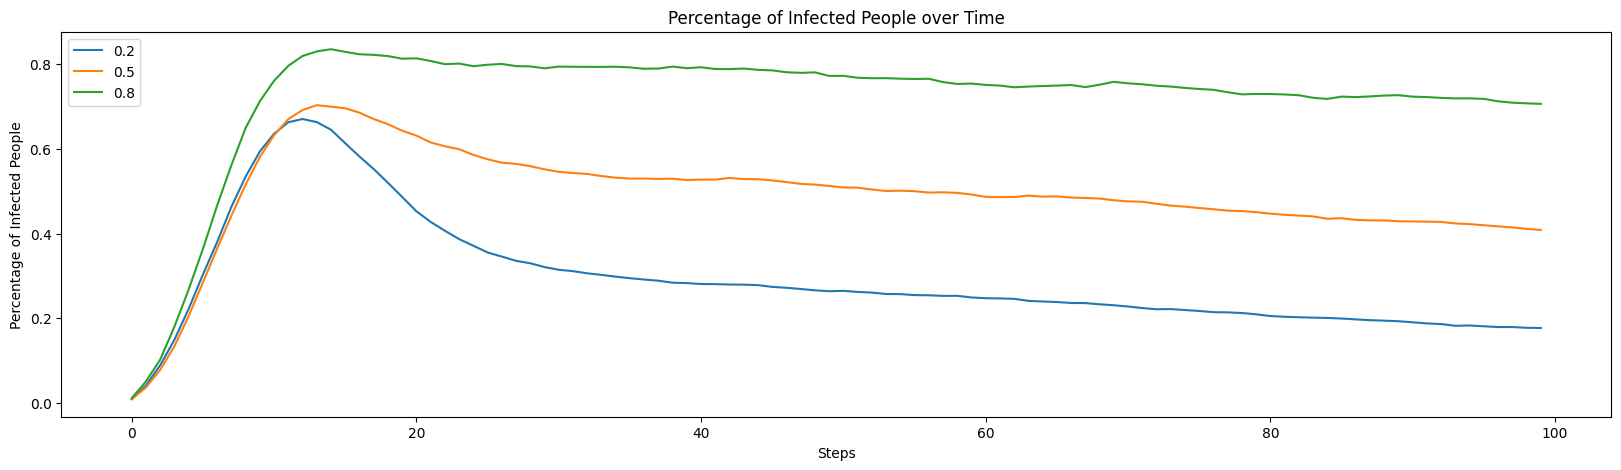

In [110]:
plt.figure(figsize=(20,5))
plt.plot(a.T)
plt.legend(v_hyper)
plt.title('Percentage of Infected People over Time')
plt.xlabel('Steps')
plt.ylabel('Percentage of Infected People')
plt.show()

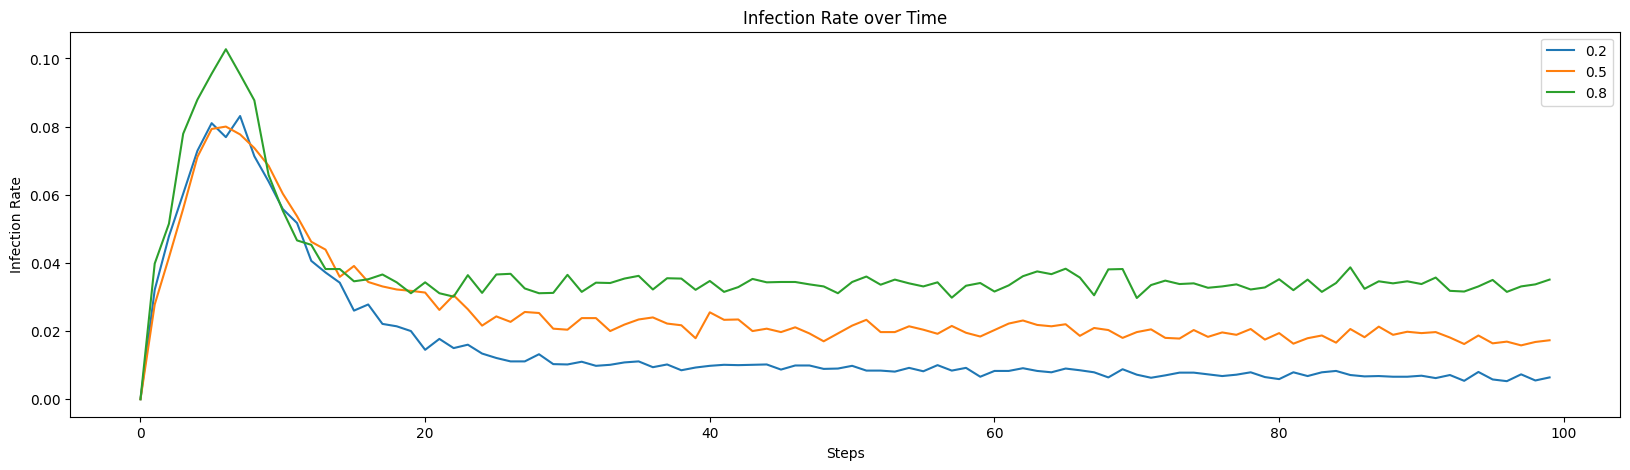

In [111]:
plt.figure(figsize=(20,5))
plt.plot(b.T)
plt.legend(v_hyper)
plt.title('Infection Rate over Time')
plt.xlabel('Steps')
plt.ylabel('Infection Rate')
plt.show()

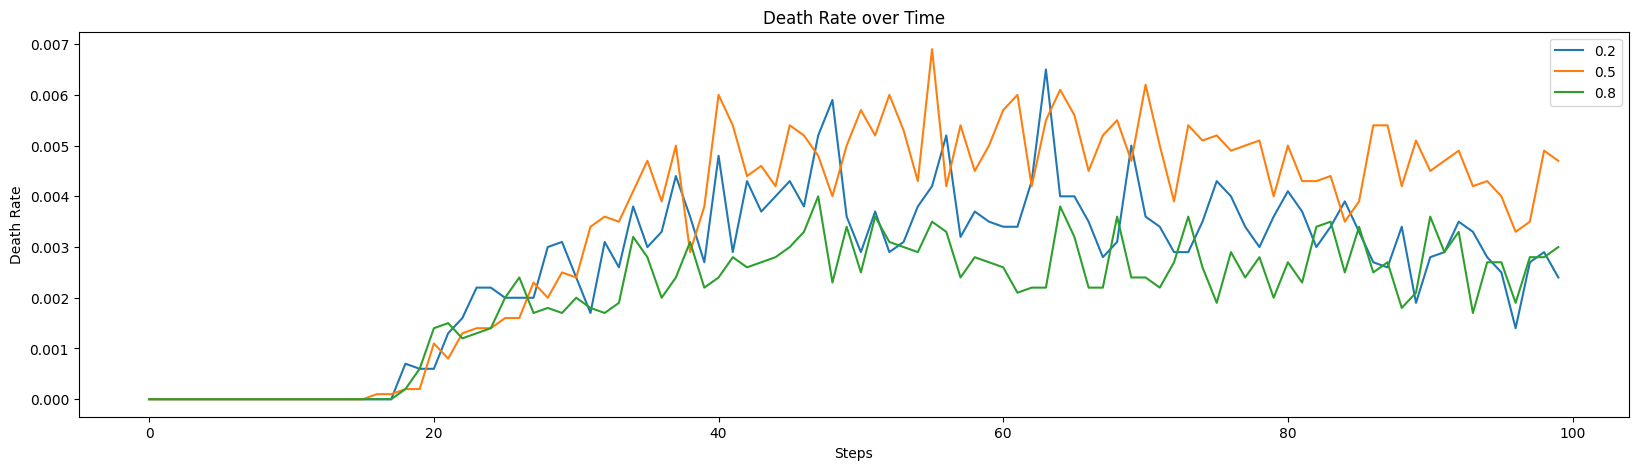

In [112]:
plt.figure(figsize=(20,5))
plt.plot(c.T)
plt.legend(v_hyper)
plt.title('Death Rate over Time')
plt.xlabel('Steps')
plt.ylabel('Death Rate')
plt.show()

### 2. Scan Space